<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


<h1>Convolutional Neural Network with Small Images</h1> 


<h2>Table of Contents</h2>
<p>You will use a Convolutional Neural Network to classify handwritten digits from the MNIST database. Images will be reshaped to make processing faster. </p>

<ul>
<li><a href="#Makeup_Data">Get Some Data</a></li>
<li><a href="#CNN">Convolutional Neural Network</a></li>
<li><a href="#Train">Define Softmax, Criterion function, Optimizer and Train the Model</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>

<hr>


In [3]:
# Using the following line code to install the torchvision library
# !mamba install -y torchvision
# !pip install torchvision==0.9.1 torch==1.8.1 

import matplotlib.pylab as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader

torch.manual_seed(0)

Define the function <code>plot_channels</code> to plot out the kernel parameters of  each channel. 


In [4]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace = 0.1)
    out_index = 0
    in_index = 0
    
    # plot outputs as rows inputs as columns
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :],
                  vmin = w_min, vmax = w_max, cmap = 'seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

Define the function <code>plot_parameters</code> to plot out the kernel parameters of each channel with multiple outputs. 


In [5]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows = 1, name = '', i = 0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel('kernel:{0}'.format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin = w_min, vmax = w_max, cmap = 'seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize = 10)
    plt.show()

Define the function <code>plot_activation</code> to plot out the activations of the convolutional layers.

In [6]:
# Define the function for plotting the activations

def plot_activations(A, number_rows = 1, name = '', i = 0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel('activation:{0}'.format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin = A_min, vmax = A_max, cmap = 'seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

Define the function <code>show_data</code> to plot out data samples as images.


In [7]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = 'gray')
    plt.title('y = '+ str(data_sample[1]))

<h2 id="Makeup_Data">Get the Data</h2> 


In [8]:
IMAGE_SIZE = 16

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                               transforms.ToTensor()])

In [9]:
train_dataset = dsets.MNIST(root = './data', train = True,
                            download = True, transform = composed)

validation_dataset = dsets.MNIST(root = './data', train = False,
                                 download = True, transform = composed)

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
# Show the data type for each element in dataset

type(train_dataset[0][1])

int

Each element in the rectangular tensor corresponds to a number representing a pixel intensity as demonstrated by the following image.


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.2.1imagenet.png" width="550" alt="MNIST data image">


In [11]:
# The label for the 4th data element

train_dataset[3][1]

1

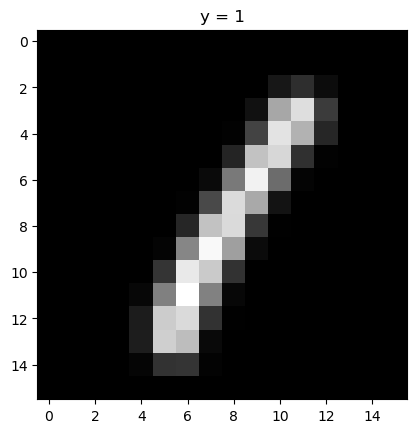

In [12]:
# The image for the 4th data element
show_data(train_dataset[3])

<h2 id="CNN">Build Convolutional Neural Network Class</h2>


Build Convolutional Network class w/ 2 convolutional layers and 1 fully connected layer. Pre-determine size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.

In [13]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1 = 16, out_2 = 32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 1,
                              out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

        self.cnn2 = nn.Conv2d(in_channels = out_1,
                              out_channels = out_2, kernel_size = 5, stride = 1, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs in each step
    def activations(self, x):
        # this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1, out

<h2 id="Train">Define the Convolutional Neural Network Classifier, Criterion function, Optimizer and Train the Model</h2> 


In [14]:
# 16 output channels for 1st layer, and 32 output channels for 2nd layer
# Create model object using CNN class

model = CNN(out_1 = 16, out_2 = 32)

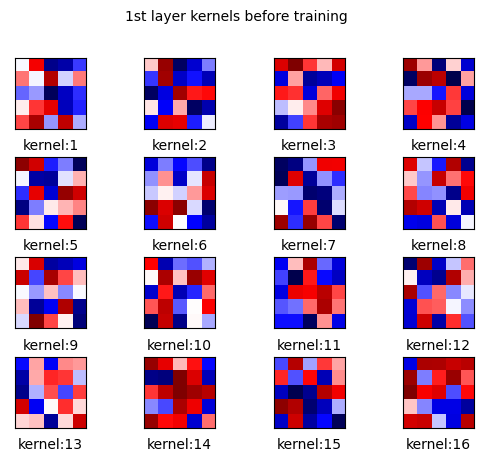

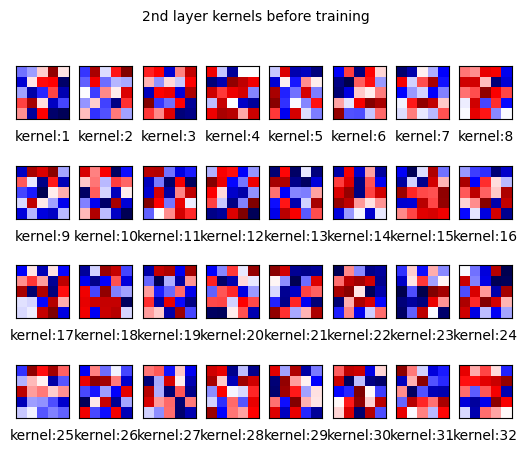

In [15]:
# Plot the parameters for the kernels before training the kernels. 
# The kernels are initialized randomly.

plot_parameters(model.state_dict()['cnn1.weight'], number_rows = 4,
                name = '1st layer kernels before training')
plot_parameters(model.state_dict()['cnn2.weight'], number_rows = 4,
                name = '2nd layer kernels before training')

In [16]:
# Define the loss function, optimizer and dataset loader

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

train_loader = DataLoader(dataset = train_dataset, batch_size = 100)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = 5000)

In [17]:
# Train the model and determine validation accuracy -- technically test accuracy.
# This may take a long time!!!

n_epochs = 3
cost_list = []
accuracy_list = []
N_test = len(validation_dataset)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        
        cost_list.append(COST)
        correct = 0
        # perform a prediction on the validation  data
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
train_model(n_epochs)

<h2 id="Result">Analyze Results</h2> 


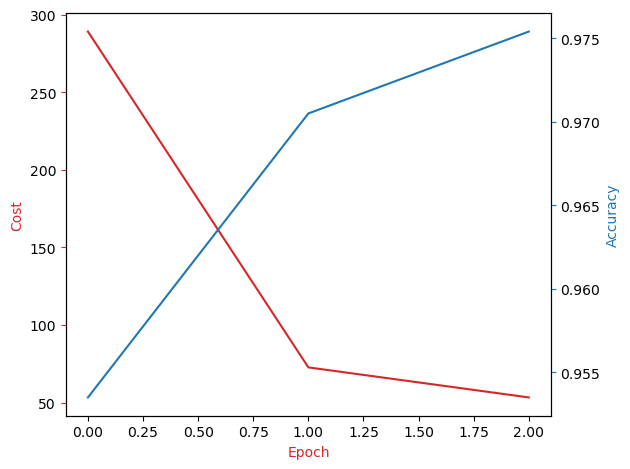

In [18]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color = color)
ax1.set_xlabel('Epoch', color = color)
ax1.set_ylabel('Cost', color = color)
ax1.tick_params(axis = 'y', color = color)
    
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color = color)
ax2.set_xlabel('Epoch', color = color)
ax2.plot(accuracy_list, color = color)
ax2.tick_params(axis = 'y', color = color)
fig.tight_layout()

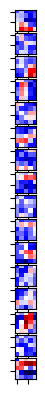

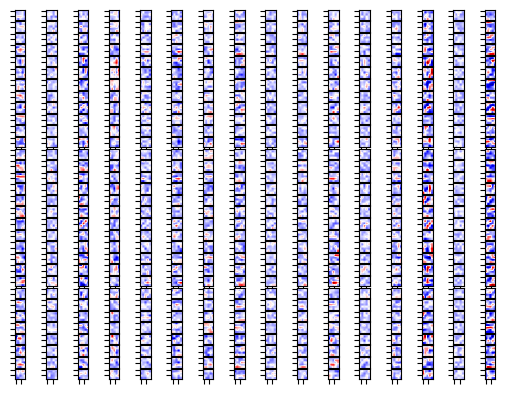

In [19]:
# Plot results of the parameters for the convolutional layers

plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

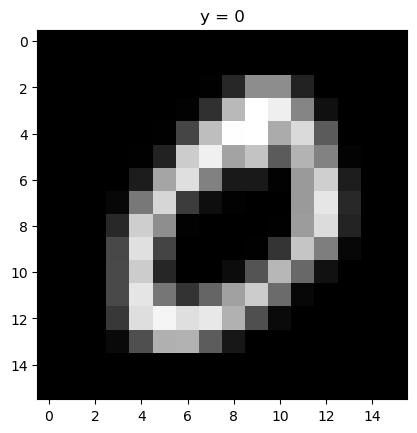

In [20]:
# Show 2nd image

show_data(train_dataset[1])

In [21]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

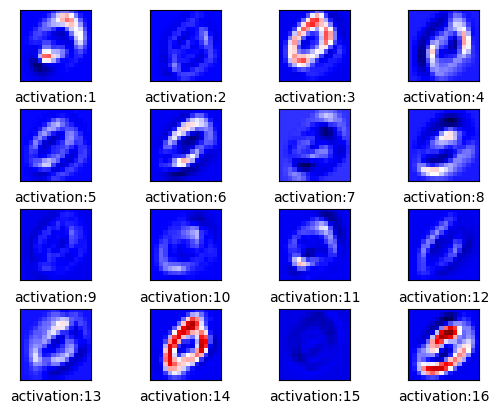

In [24]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows = 4)

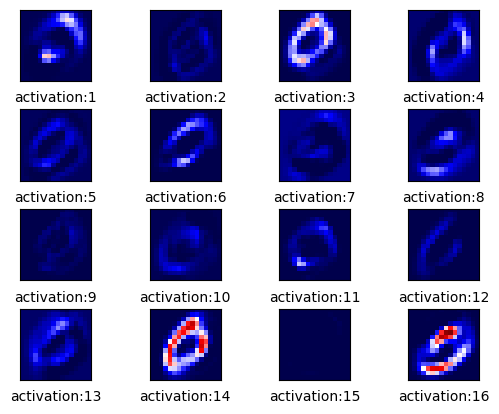

In [25]:
# Plot the outputs after 1st ReLU

plot_activations(out[1], number_rows = 4)

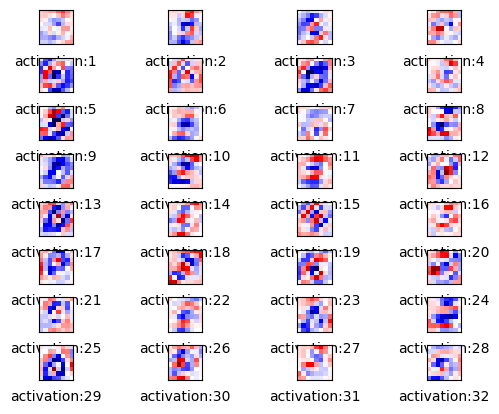

In [28]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows = 32 // 4)

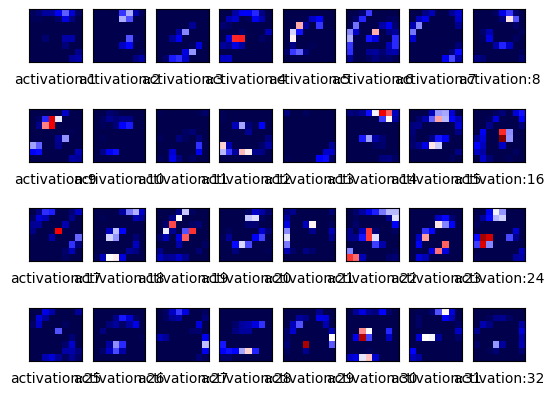

In [29]:
# Plot the outputs after 2nd ReLU

plot_activations(out[3], number_rows = 4)

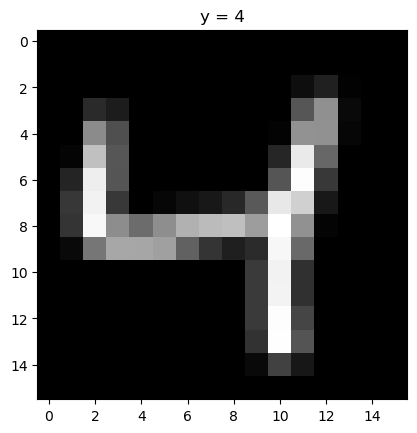

In [30]:
# Show 3rd image

show_data(train_dataset[2])

In [31]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[2][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

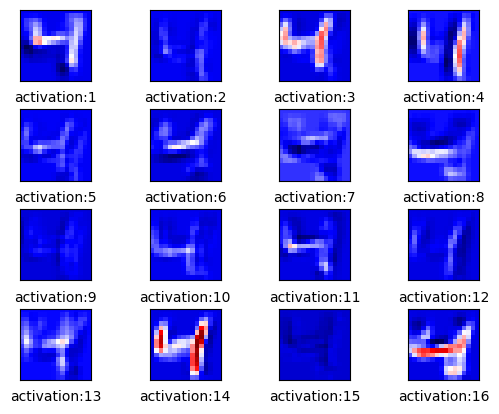

In [32]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows = 4, name = "Output after the 1st CNN")

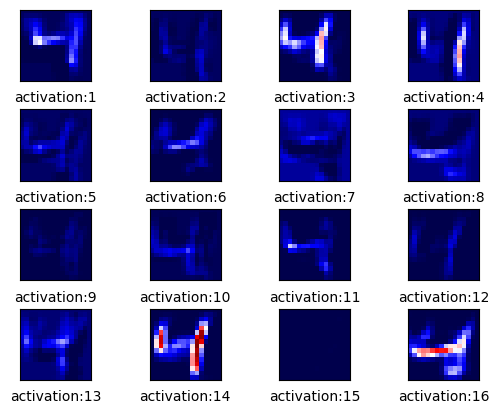

In [33]:
# Plot the outputs after the first Relu

plot_activations(out[1], number_rows = 4, name = "Output after the 1st Relu")

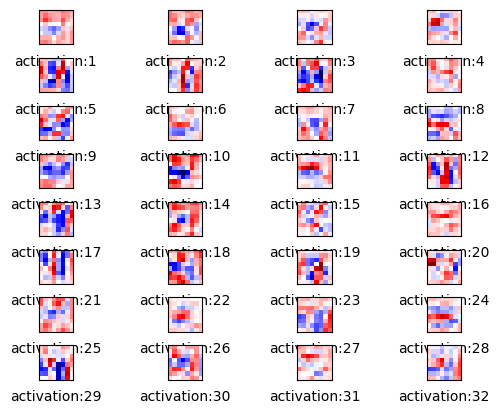

In [34]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows = 32 // 4, name = "Output after the 2nd CNN")

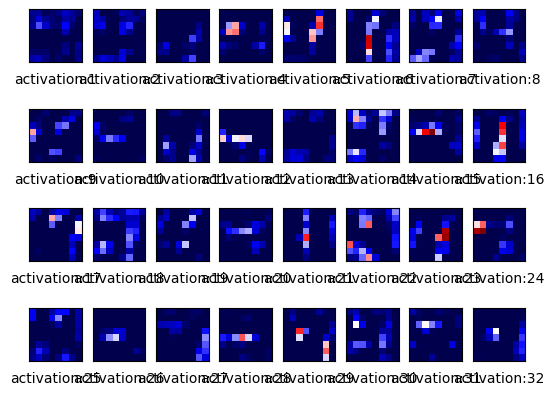

In [35]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows = 4, name = "Output after the 2nd Relu")

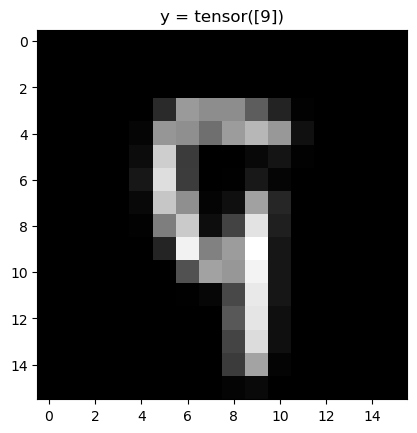

yhat:  tensor([5])


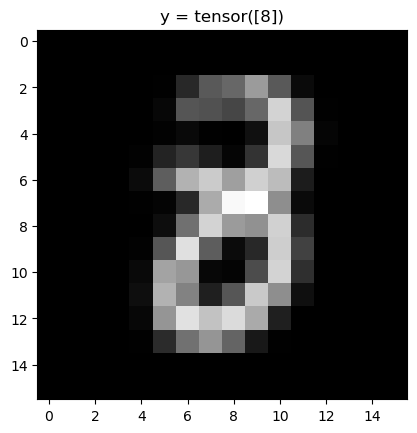

yhat:  tensor([3])


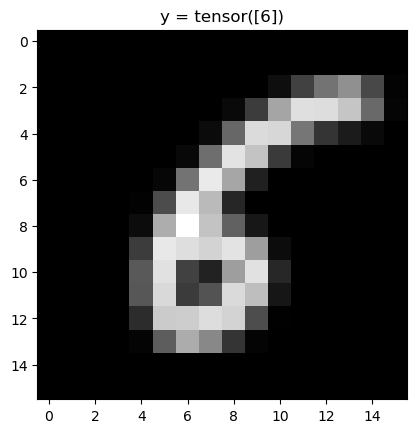

yhat:  tensor([5])


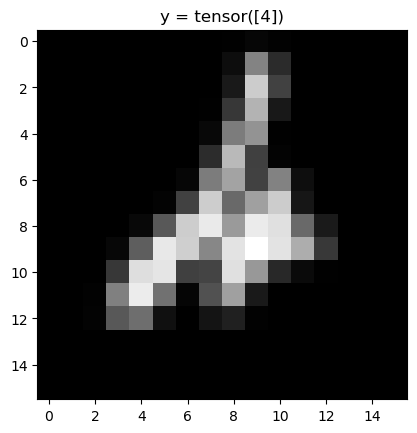

yhat:  tensor([2])


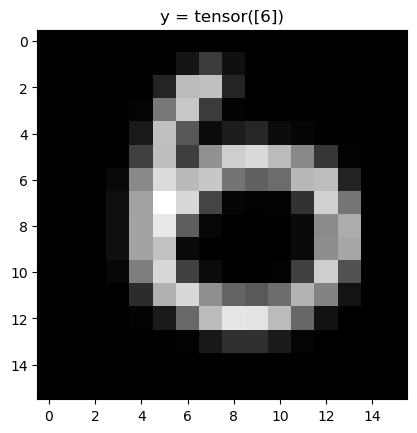

yhat:  tensor([0])


In [36]:
# Plot the 5 mis-classified samples

count = 0
for x, y in DataLoader(dataset = validation_dataset, batch_size = 1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ", yhat)
        count += 1
    if count >= 5:
        break